In [ ]:
"""
Script to process all the LCDRI data, generate 1D surface wave spectra, and calculate significant wave heights.

This script also generates Figures 5 and 6

"""

In [1]:
from scipy.io import loadmat, savemat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
import sys
sys.path.insert(0, '/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveProcessing/src')
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings


cdip_color='#F5B958'
red_color = '#D81159'
gray_color= '#2E2836'

In [2]:
#Directory containing all the Em-APEX Data
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
#Process EM-APEX 1Hz data
big_arr = process_files(fname_base)


#Unpack the results
spec_store_sorted = big_arr[0]
time_store_sorted = big_arr[1]
uncertainty_store_sorted = big_arr[2]
up_down_store_sorted = big_arr[3]
loc_store_sorted = big_arr[4]
prof_store_sorted = big_arr[5]
prof_speed_store_sorted = big_arr[6]
rotf_store_sorted = big_arr[7]
depth_store_sorted = big_arr[8]
fwindow = big_arr[9]

/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0062-efr.mat


/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/opt/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [3]:
#Unpack the raw (uncorrected) and correced spectra
spec_store_sorted_new_raw = spec_store_sorted[:, 0, :]
spec_store_sorted_new_corr = spec_store_sorted[:, 1, :]

#Get EM-APEX Dates in datetime 
t_apex = np.array([datetime.datetime.fromtimestamp(t) for t in time_store_sorted])


#Add Hf tail to specta to get same frequency range as Waverider. 
spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted_new_corr, fwindow)

#Calculate swh and errors
[Hs,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_raw))
[Hs_corr, lower, upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr), uncertainty_store_sorted)

errors = np.zeros((2, len(lower)))
errors[0,:]=lower
errors[1,:]=upper




In [6]:
#Load CDIP Data
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"

nc = netcdf.NetCDFFile(fname, 'r', mmap=False) 
times = nc.variables['waveTime'][:]
ts = np.array([datetime.datetime.fromtimestamp(t) for t in times])
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]
cdip_lat = np.nanmean(nc.variables['gpsLatitude'][:])
cdip_lon = np.nanmean(nc.variables['gpsLongitude'][:])



/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_16003/3119660756.py:4: DeprecationWarning: `scipy.io.netcdf.NetCDFFile` is deprecated along with the `scipy.io.netcdf` namespace. `scipy.io.netcdf.NetCDFFile` will be removed in SciPy 1.14.0, and the `scipy.io.netcdf` namespace will be removed in SciPy 2.0.0.
  nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning


# Generate Figure 5, showing spectral evolution over the LCDRI experiment

In [7]:
#Bin spectra by time
tbin = np.array([], dtype='int')
t_store_tbinned = np.array([])
spec_store_tbinned = np.array([])
for t_ind in range(len(t_apex)):
    if not np.any(tbin):
        tbin = np.append(tbin, int(t_ind))
    else:
        if t_apex[t_ind]-t_apex[tbin[0]]<datetime.timedelta(minutes=30):
            tbin = np.append(tbin, int(t_ind))
            
        else:
            #Average the spectra with teh right bin indicies?
            #temp spec should be [1, 59]
            temp_spec = np.nanmean(spec_store_sorted[tbin, 1, :], axis=0)
            mid_t = tbin[0]+(tbin[-1]-tbin[0])//2
            temp_t = t_apex[mid_t]
            tbin  = np.array([], dtype='int')
            
            if not np.any(spec_store_tbinned):
                spec_store_tbinned = np.expand_dims(temp_spec, axis=0)
                t_store_tbinned = temp_t
            else:
                spec_store_tbinned = np.append(spec_store_tbinned, np.expand_dims(temp_spec, axis=0), axis=0)
                t_store_tbinned = np.append(t_store_tbinned, temp_t)

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_16003/1354239526.py:15: RuntimeWarning: Mean of empty slice
  temp_spec = np.nanmean(spec_store_sorted[tbin, 1, :], axis=0)


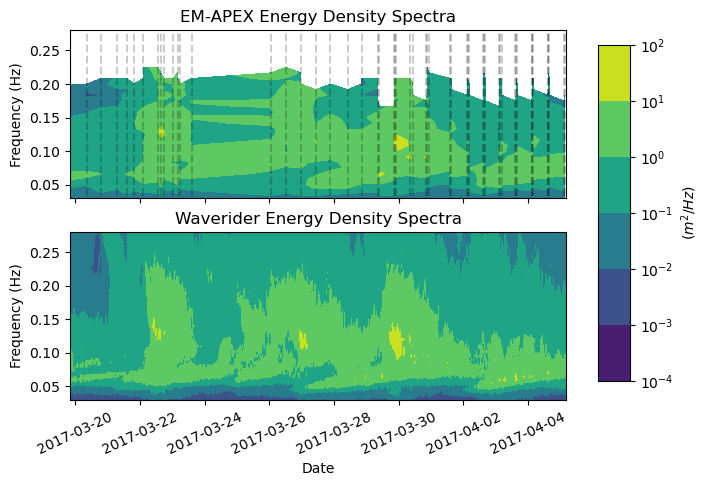

In [8]:
#Compare EM-APEX Spectra with Waverider. Show vertical lines at times of EM-APEX 1Hz measurements.

from matplotlib import cm, ticker

fig, axes = plt.subplots(nrows=2, ncols=1)

#For getting uniformly-spaced x-axis
xtick_times = ts[0::100]

#p#lt.subplot(211)
ax1=axes[0]
ax2=axes[1]
ax1.contourf(t_store_tbinned, fwindow, spec_store_tbinned.T, locator=ticker.LogLocator(), vmin=10**-4, vmax=10**2)

ax1.tick_params(
    axis='x',          # changes apply to the x-axis        # ticks along the top edge are off
    labelbottom=False)
ax1.vlines(x=t_store_tbinned, ymin=0, ymax=0.3, color='k', linestyle='--', alpha=0.2)
ax1.set_ylim([0.03, 0.28])
#ax1.set_yscale('log')
ax1.set_ylabel("Frequency (Hz)")
ax1.set_title("EM-APEX Energy Density Spectra")
#ax1.colorbar()
ax1.xaxis.set_ticks(xtick_times) #set the ticks to be uniform
ax1.set_xlim([t_apex[0], t_apex[-1]])
ax1.ticklabel_format(axis='y', style='plain')

#plt.subplot(212)
im = ax2.contourf(ts, wave_freq, energy_density.T, locator=ticker.LogLocator(), vmin=10**-4, vmax=10**2)

ax2.set_ylim([0.03, 0.28])
#ax2.set_yscale('log')
#plt.colorbar()
ax2.set_xlabel('Date')
ax2.set_ylabel("Frequency (Hz)")
ax2.set_title("Waverider Energy Density Spectra")
ax2.xaxis.set_ticks(xtick_times) #set the ticks to be uniform
ax2.set_xlim([t_apex[0], t_apex[-1]])
ax2.ticklabel_format(axis='y', style='plain')


# Rotating X-axis labels
for tick in ax2.get_xticklabels():
    tick.set_rotation(25)

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$(m^2/Hz)$', rotation=90, loc='center')
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/spectra_tseries.png", bbox_inches='tight')


#Saving fig 5 stuff.
#np.savez("/Users/jamesstadler/Documents/UW/TFO/Data/PaperData/Attempt2/Fig5/fig5_data", waverider_time = ts, waverider_f = wave_freq, waverider_spec = energy_density.T, apex_time = t_store_tbinned, apex_f = fwindow[1:], apex_spec = spec_store_tbinned.T)

# Generate Figure 6

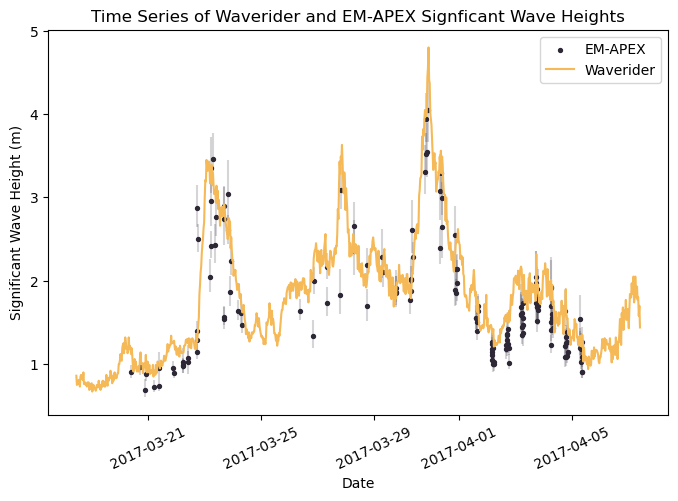

In [9]:
#Generate Figure 6, save it and data.

plt.figure(figsize=(8,5))
plt.scatter(t_apex, Hs_corr, color=gray_color, s=8, label='EM-APEX')
plt.errorbar(t_apex, Hs_corr, yerr = errors, color=gray_color, alpha=0.2, fmt='none')

plt.plot(ts, Hs_cdip, label='Waverider', color='#F5B958')


plt.ylabel("Significant Wave Height (m)")
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Time Series of Waverider and EM-APEX Signficant Wave Heights")
plt.legend()
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/JTECH_Manuscript/proof_files/Timeseries_alone2.png", bbox_inches='tight', dpi=600)
#np.savez("/Users/jamesstadler/Documents/UW/TFO/Data/PaperData/Attempt2/fig6_data", apex_time = t_apex, apex_hs = Hs_corr, waverider_time = ts, waverider_hs = Hs_cdip)

In [10]:

#Load SWIFT 
all_swift_file = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/SWIFT/testswiftnew.mat"

SWIFT_new = loadmat(all_swift_file)
swift_arr = np.array([[0,0,0,0, 0]])
for i in range(len(SWIFT_new['swift'][0, 0])):
    lat_arr = np.array([])
    lon_arr = np.array([])
    swift_temp = SWIFT_new['swift'][0, 0][i]
    #time = swift_temp[0, 0][0][0]
    #lon = swift_temp[0, 0][1][0]
    #lat = swift_temp[0, 0][2][0]
    #wavesigH = swift_temp[0, 0][9][0]
    mdtype = swift_temp.dtype
    ndata = {n: swift_temp[n] for n in mdtype.names}
    columns = [n for (n, v) in ndata.items()]
    df = pd.DataFrame(np.concatenate([ndata[c] for c in columns], axis=1, dtype='object'), columns=columns)
    lat=np.array(df['lat'][0], dtype=float).T
    lon=np.array(df['lon'][0], dtype=float).T
    time = np.array(df['time'][0], dtype=float).T
    hs = np.array(df['wavesigH'][0], dtype=float).T
    wave_dir = np.array(df['wavepeakdir'][0], dtype=float).T
    #lat_arr = np.expand_dims(lat, axis=1)
    #lon_arr = np.expand_dims(lon, axis=1)
    #time_arr = np.expand_dims(time, axis=1)
    #hs_arr = np.expand_dims(hs, axis=1)

    swift_temp_arr = np.hstack((time, lon, lat, hs, wave_dir))
    swift_arr = np.vstack((swift_arr, swift_temp_arr))

swift_arr = np.delete(swift_arr, 0, 0)

#swift_arr2=swift_arr2[swift_arr[:, 0].argsort()]
swift_arr = swift_arr[swift_arr[:, 0].argsort()]

swift_t_out=datenum_to_datetime(swift_arr[:, 0])

In [18]:
#Calculate energy weighted periods
num = np.trapz(spec_store_sorted_new_corr, x=fwindow)
denom = np.trapz(fwindow*spec_store_sorted_new_corr, x=fwindow)
Te = num/denom

num_cdip = np.trapz(energy_density, x=wave_freq)
denom_cdip = np.trapz(wave_freq*energy_density, x=wave_freq)
Te_cdip = num_cdip/denom_cdip


start_freq = 0.05
cutoff_freq = 0.2
end_f = np.where(fwindow<cutoff_freq)[-1][-1]
start_f = np.where(fwindow>start_freq)[0][0]
end_f_cdip  =np.where(wave_freq<cutoff_freq)[-1][-1]
start_f_cdip  =np.where(wave_freq>start_freq)[0][0]
num = np.trapz(spec_store_sorted_new_corr[:, start_f:end_f], x=fwindow[start_f:end_f])
denom = np.trapz(fwindow[start_f:end_f]*spec_store_sorted_new_corr[:, start_f:end_f], x=fwindow[start_f:end_f])
Te_cutoff = num/denom

num_cdip = np.trapz(energy_density[:, start_f_cdip:end_f_cdip], x=wave_freq[start_f_cdip:end_f_cdip])
denom_cdip = np.trapz(wave_freq[start_f_cdip:end_f_cdip]*energy_density[:, start_f_cdip:end_f_cdip], x=wave_freq[start_f_cdip:end_f_cdip])
Te_cdip_cutoff = num_cdip/denom_cdip


#Get peak frequencies
[peak_freq, peak_spl] = get_peak_freq(fwindow, spec_store_sorted_new_corr)
[peak_freq_cdip, peak_spl_cdip] = get_peak_freq(wave_freq, energy_density)

In [19]:
#Save a bunch of the processed data for plotting

np.savez("/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/intermediate_processed_data/hs_data", errors = errors, swift_t = swift_t_out, swift_arr=swift_arr, t_apex=t_apex, Hs_corr=Hs_corr, Hs_cdip=Hs_cdip, loc_store_sorted=loc_store_sorted, ts=ts, Te_cdip = Te_cdip_cutoff, Te=Te_cutoff, peak_freq_cdip=peak_freq_cdip, peak_freq=peak_freq)

# Some code for comparing simulated float observations with real observations

In [5]:
warnings.filterwarnings('ignore')
base_savename = "/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float/"
#[spec_store_sorted_fake, time_store_sorted_fake, uncertainty_store_sorted_fake, up_down_store_sorted_fake, loc_store_sorted_fake, prof_store_sorted_fake, fwindow_fake] = process_files(base_savename, sim=True)
big_arr_fake = process_files(base_savename, sim=True)
#Unpack the results
spec_store_sorted_fake = big_arr_fake[0]
time_store_sorted_fake = big_arr_fake[1]
uncertainty_store_sorted_fale = big_arr_fake[2]
up_down_store_sorted_fale = big_arr_fake[3]
loc_store_sorted_fake = big_arr_fake[4]
prof_store_sorted_fake = big_arr_fake[5]
prof_speed_store_sorted_fake = big_arr_fake[6]
rotf_store_sorted_fake = big_arr_fake[7]
depth_store_sorted_fake = big_arr_fake[8]
fwindow_fake = big_arr_fake[9]


/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float/6667g/dec/ema-6667g-0042-10-efr.mat
/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float/6667g/dec/ema-6667g-0042-3-efr.mat
/Users/jamesstadler/Documents/UW/TFO/Data/Simulations/mimic_float/6667i/dec/ema-6667i-0062-18-efr.mat


NameError: name 'fwindow' is not defined

In [6]:
spec_store_sorted_new_corr_fake = add_hf_tail(spec_store_sorted_fake[:, 1, :], fwindow_fake)
[Hs_fake_angs_speed,lower,upper] = sig_wave_height(fwindow_fake, np.transpose(spec_store_sorted_new_corr_fake))
t_apex_fake = np.array([datetime.datetime.fromtimestamp(t) for t in time_store_sorted_fake])

NameError: name 'fwindow' is not defined

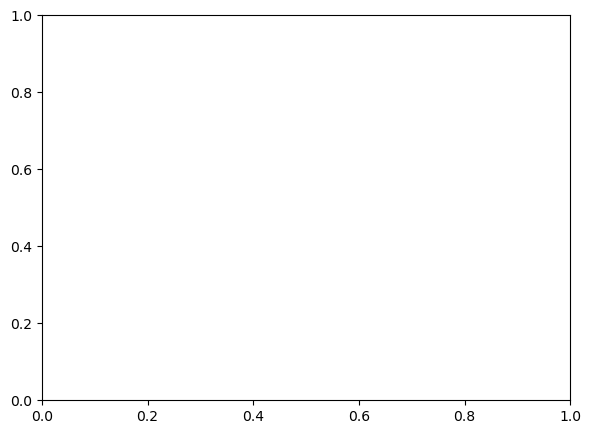

In [7]:
#First getting the 

t_apex_uniques = np.array([])
for t in t_apex_fake:
    if t in t_apex_uniques:
        continue
    else:
        t_apex_uniques = np.append(t_apex_uniques, [t])
        
Hs_means_sim = np.array([])
Hs_stds_sim = np.array([])
spec_store_means_sim = np.zeros((len(t_apex_uniques), len(fwindow_fake)))
spec_store_stds_sim = np.zeros((len(t_apex_uniques), len(fwindow_fake)))
counter=0
for t in t_apex_uniques:
    inds = np.where(t_apex_fake==t)
    avg_sim = np.nanmean(Hs_fake_angs_speed[inds])
    stdeviation_sim = np.nanstd(Hs_fake_angs_speed[inds])
    Hs_means_sim = np.append(Hs_means_sim, [avg_sim])
    Hs_stds_sim = np.append(Hs_stds_sim, [stdeviation_sim])

    spec_store_means_sim[counter, :] = np.nanmean(spec_store_sorted_new_corr_fake[inds[0], :], axis=0)
    spec_store_stds_sim[counter, :] = (spec_store_means_sim[counter, :]+2*np.nanstd(spec_store_sorted_new_corr_fake[inds[0], :], axis=0))/spec_store_means_sim[counter, :]
    counter+=1

#Replotting as above



ind=22
plt.figure(figsize=(15,5))
plt.subplot(122)
plt.fill_between(fwindow[1:],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 0],color='0.8')
plt.loglog(fwindow[1:], spec_store_sorted_new_raw[ind, :], label="EM-APEX raw", color=gray_color, alpha=0.2)
plt.loglog(fwindow[1:], spec_store_sorted_new_corr[ind, :], label="EM-APEX corrected", color=gray_color)
plt.loglog(fwindow[1:], spec_store_means_sim[ind, :], label="Simulation", color=red_color)
plt.fill_between(fwindow[1:],spec_store_means_sim[ind, :]/spec_store_stds_sim[ind, :],spec_store_means_sim[ind, :]*spec_store_stds_sim[ind, :],color=red_color, alpha=0.2)


plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Energy Density ($m^2$/Hz)")

ind2 = np.where(np.abs(t_apex[ind]-ts)==np.min(np.abs(t_apex[ind]-ts)))
plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP", color=cdip_color)


plt.legend()

plt.title("Sample EM-APEX and CDIP spectrum (float 6675g, profile #22)")
print(prof_store_sorted[ind])

plt.subplot(121)
plt.scatter(t_apex, Hs_corr, color=gray_color, s=8, label='EM-APEX Float')
plt.scatter(t_apex_uniques, Hs_means_sim, color=red_color, s=8, label='Simulation', )
plt.errorbar(t_apex, Hs_corr, yerr = errors, color=gray_color, alpha=0.2, fmt='none')
plt.errorbar(t_apex_uniques, Hs_means_sim, yerr = 2*Hs_stds_sim, color=red_color, alpha=0.2, fmt='none')

plt.plot(ts, Hs_cdip, label='CDIP', color='#F5B958')

#plt.scatter(swift_t_out, swift_arr[:, 3], s=6, alpha=0.2, color='k')

plt.ylabel("Significant Wave Height (m)")
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Time Series of CDIP and EM-APEX Signficant Wave Height")
plt.legend()
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Timeseries_spectrum_w_sim.png", bbox_inches='tight')

In [8]:
#Loop for saving out each spectrum (with error bounds)
#ind = 1
for ind in range(0, len(Hs_corr)):
    plt.figure()
    plt.loglog(fwindow, spec_store_sorted_new_raw[ind, :], label="EM-APEX raw")
    plt.loglog(fwindow, spec_store_sorted_new_corr[ind, :])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(r"Energy Density ($m^2$/Hz)")
    #plt.loglog(np.log(fwindow[1:]), p(np.log(fwindow[1:])))
    #a = np.exp(fit[1])
    #b = -2#fit[0]
    #a = spec_store_sorted_new_raw[ind, 0]/np.exp(b * np.log(fwindow[1]))
    #y_fitted = a * np.exp(b * np.log(fwindow[1:]))

    #plt.loglog(fwindow[1:], y_fitted)
    #plt.loglog(fwindow[1:], spec_store_sorted_new_raw[-4, :]-y_fitted)
    ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))
    plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")


    #practice getting a high frequency fit
    #end_ind = np.where(np.isnan(spec_store_sorted_new_corr[ind, :]))[0][0]-1
    #f_end = fwindow[1+end_ind]
    #E_end = spec_store_sorted_new_corr[ind, end_ind]
    #b = np.log10(E_end)+5*np.log10*
    #c = E_end/f_end**(-4)
    #extension = np.power(fwindow[1:], -4)*c
    #extension[:end_ind]=0
    #temp_spec = np.copy(spec_store_sorted_new_corr[ind, :])
    #temp_spec[end_ind:]=0
    #plt.loglog(fwindow[1:], extension)

    #PLot highfrequency fit
    plt.loglog(fwindow[1:], spec_store_sorted_new_corr[ind, :], label="EM-APEX corrected")
    plt.fill_between(fwindow[1:],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 0],color='0.8')
    plt.legend()
    if up_down_store_sorted[ind]:
        plt.title("Prof # "+str(ind)+" (up)")
    else:
        plt.title("Prof # "+str(ind)+" (down)")

    plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/EmApex_spectra/prof_"+f'{ind:03}'+".png", bbox_inches='tight')

    plt.close()
    #print(Hs[ind])
   # print(Hs_cdip[ind2])
    #print(extended_swh)
    
    #extended_spec.shape
    #print(spec_store_sorted_new_corr.shape)
    #print(up_down_store_sorted[ind])

6675g_22
3.0551469923789436 3.7265538438294215
[3.049984200834859, 3.7342824520320557]


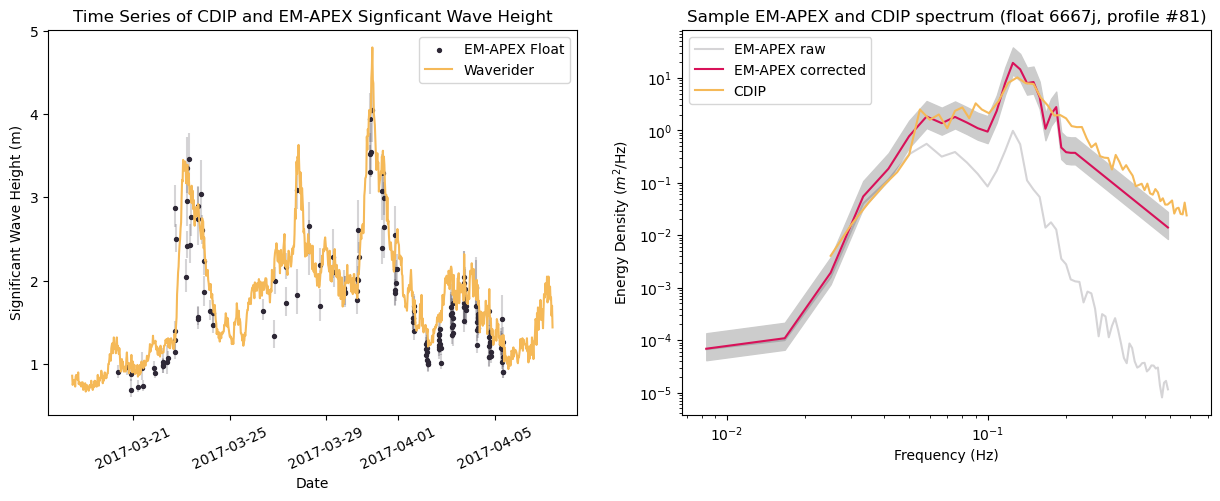

In [20]:
#Cell for checking individual spectra. Just change "ind" to whatever spectra you want to look at (sorted by time)
%matplotlib inline
#ind = 68 #This is the bad one
#ind = 22 # This is the one for hte figure in the paper
ind=112
ind=22
plt.figure(figsize=(15,5))
plt.subplot(122)
plt.fill_between(fwindow,spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 0],color='0.8')
#plt.fill_between(fwindow[1:],uncertainty_store_sorted[ind, 1],uncertainty_store_sorted[ind, 0],color='0.8')
plt.loglog(fwindow, spec_store_sorted_new_raw[ind, :], label="EM-APEX raw", color=gray_color, alpha=0.2)
plt.loglog(fwindow, spec_store_sorted_new_corr[ind, :], label="EM-APEX corrected", color=red_color)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Energy Density ($m^2$/Hz)")

ind2 = np.where(np.abs(t_apex[ind]-ts)==np.min(np.abs(t_apex[ind]-ts)))
plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP", color=cdip_color)


plt.legend()

plt.title("Sample EM-APEX and CDIP spectrum (float 6667j, profile #81)")
print(prof_store_sorted[ind])

plt.subplot(121)
plt.scatter(t_apex, Hs_corr, color=gray_color, s=8, label='EM-APEX Float')
#plt.scatter(t_apex[downs], Hs_corr[downs], color=red_color, s=8, label='Down', )
plt.errorbar(t_apex, Hs_corr, yerr = errors, color=gray_color, alpha=0.2, fmt='none')
#plt.errorbar(t_apex[downs], Hs_corr[downs], yerr = errors[:, downs], color=red_color, alpha=0.2, fmt='none')

plt.plot(ts, Hs_cdip, label='Waverider', color='#F5B958')

#plt.scatter(swift_t_out, swift_arr[:, 3], s=6, alpha=0.2, color='k')

plt.ylabel("Significant Wave Height (m)")
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Time Series of CDIP and EM-APEX Signficant Wave Height")
plt.legend()
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/Timeseries_spectrum_test.png", bbox_inches='tight')
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Timeseries_spectrum.png", bbox_inches='tight')
nu_s =2*11* np.square(np.sum(spec_store_sorted_new_corr[ind, :]))/np.sum(np.square(spec_store_sorted_new_corr[ind, :]))
import scipy
llim = np.sqrt(nu_s/scipy.stats.chi2.ppf(1-.05/2, df=nu_s))*Hs_corr[ind]
ulim = np.sqrt(nu_s/scipy.stats.chi2.ppf(.05/2, df=nu_s))*Hs_corr[ind]
print(Hs_corr[ind]-errors[0, ind], Hs_corr[ind]+errors[1, ind])
print([llim, ulim])

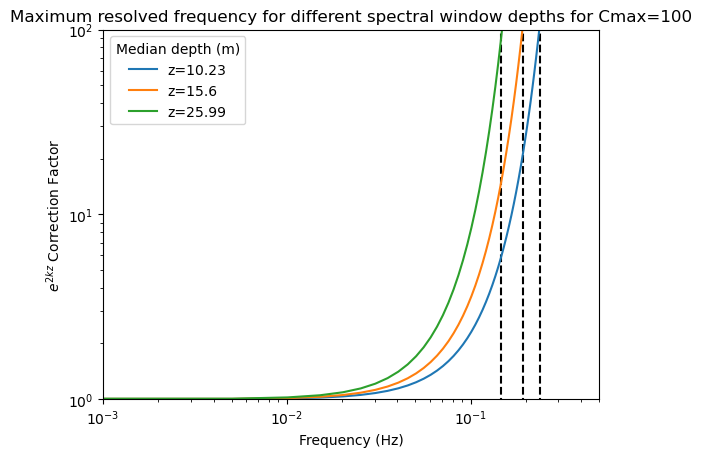

In [121]:
#<What's the maximimum resolved freqeuncy for different depth bins?
f = np.linspace(0, 0.5, 100)
k = np.square(2*np.pi*f)/9.8
z_arr = [6, 8, 10, 12, 16, 20, 24, 30]
z_arr = [12.78, 18.5]
z_arr = [10.23, 15.6, 25.99]
max_freqs = np.zeros(len(z_arr))
counter=0
Cmax = 100
plt.figure()
plt.set_cmap('tab10')
for z in z_arr:
    plt.loglog(f, np.exp(2*k*z), label='z='+str(z))
    max_ind = np.where(np.abs(np.exp(2*k*z)-Cmax)==np.min(np.abs(np.exp(2*k*z)-Cmax)))
    plt.vlines(x=f[max_ind], ymin=0, ymax=Cmax, linestyle='--', color='k')
    max_freqs[counter]=f[max_ind]
    counter+=1
plt.ylim(1, Cmax)
plt.xlim(0.001, 0.5)
plt.legend(title="Median depth (m)")

plt.xlabel("Frequency (Hz)")
plt.ylabel(r'$e^{2kz}$ Correction Factor')

plt.title("Maximum resolved frequency for different spectral window depths for Cmax=100")


#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/DepthCorrection_Impact.png", bbox_inches='tight')
